# Machine Learning I Final Project

Team 4

Rebecca Li, Jackie Li, Chris Chou, Niki Baskar

In [1]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding, Flatten, Input, concatenate
from keras_tuner import BayesianOptimization, RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import keras.backend as K
import sklearn
import category_encoders as ce
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras import initializers
from datatable import dt, f, by, g, join, sort, update, ifelse
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Data Exploration

## Data Import

In [2]:
# Import the training data
train = pd.read_csv('Project Data/ProjectTrainingData.csv')

In [3]:
# Import the test data
test = pd.read_csv('Project Data/ProjectTestData.csv')

In [ ]:
train.shape
# there are 31991090 rows and 24 columns

(31991090, 24)

In [4]:
# shuffle the train dataset into 10 parts
shuffled = train.sample(frac=1,random_state=42)
result = np.array_split(shuffled, 10)  

In [5]:
# name those parts with number
for i in range(len(result)):
    exec(f'train_{i} = result[i]')

In [6]:
print(train_3.shape)

(3199109, 24)


## Data Overview

In [7]:
# Explore the training data
train_3.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
5616589,1.211469e+19,0,14102210,1005,1,5114c672,3f2f3819,3e814130,ecad2386,7801e8d9,...,1,0,21764,216,36,2506,0,35,100076,157
31825749,1.028758e+19,0,14102922,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32
13548281,1.757268e+19,1,14102413,1005,0,2b1ddb24,98acf46c,3e814130,ecad2386,7801e8d9,...,1,0,20128,320,50,2303,2,39,100148,23
11682204,7.256027e+18,0,14102322,1005,0,85f751fd,c4e18dd6,50e219e0,8bcb1385,2347f47a,...,1,0,15708,320,50,1722,0,35,-1,79
29186795,1.731978e+18,0,14102904,1005,0,8d7e1373,3b953bf0,75fa27f6,ecad2386,7801e8d9,...,1,0,22951,320,50,2654,3,38,-1,23


In [8]:
# set test set naive prediction value as 0.5
test['click'] = 0.5
# set test set column names
test = test[['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 
                    'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]

In [9]:
test.shape

(13015341, 24)

In [10]:
train_3.describe(include='all')

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3199109,3199109,3199109,3199109,3199109,...,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06,3.199109e+06
unique,NaN,NaN,NaN,NaN,NaN,3278,4010,23,4586,294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1117161,1160312,1273551,2081948,2199153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.221241e+18,1.697601e-01,1.410251e+07,1.004971e+03,2.939415e-01,NaN,NaN,NaN,NaN,NaN,...,1.018046e+00,3.294061e-01,1.858709e+04,3.188324e+02,6.017037e+01,2.081027e+03,1.432369e+00,2.217995e+02,5.364687e+04,8.052746e+01
std,5.325019e+18,3.754219e-01,2.675345e+02,1.116570e+00,5.107964e-01,NaN,NaN,NaN,NaN,NaN,...,5.407373e-01,8.574898e-01,4.972518e+03,2.145895e+01,4.760673e+01,6.093760e+02,1.323083e+00,3.495668e+02,4.992757e+04,6.698060e+01
min,6.644102e+12,0.000000e+00,1.410210e+07,1.001000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,4.609702e+18,0.000000e+00,1.410222e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,1.661500e+04,3.200000e+02,5.000000e+01,1.800000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,9.218715e+18,0.000000e+00,1.410251e+07,1.005000e+03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.015300e+04,3.200000e+02,5.000000e+01,2.299000e+03,2.000000e+00,3.900000e+01,1.000550e+05,6.100000e+01
75%,1.383416e+19,0.000000e+00,1.410280e+07,1.005000e+03,1.000000e+00,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,0.000000e+00,2.177000e+04,3.200000e+02,5.000000e+01,2.506000e+03,3.000000e+00,1.690000e+02,1.000940e+05,9.100000e+01


In [11]:
# # concat all data to explore
# df = pd.concat([train, test])
# # transform into a datatable just in case of speed limit
# all_dt = dt.Frame(df)

## Categorical Data Encoding

Category with names:
* id: drop
* site categories:
  * site_id: base 5 encoding
  * site_domain: base 5 encoding
  * site_category: base 10 encoding
* app cats:
  * app_id: base 5 encoding
  * app_domain: one-hot encoding
  * app_category: base 10 encoding
* device cats:
  * device_id: one-hot encoding
  * device_ip: drop
  * device_model: base 10 encoding


Category without names:
* C1: stay same
* C14: base 5 encoding
* C15: stay same
* C16: stay same
* C17: base 5 encoding
* C18: stay same
* C19: base 5 encoding
* C20: base 5 encoding
* C21: base 5 encoding

In [12]:
# drop id in column
del train_3['id']
del test['id']

In [13]:
# define a function to transform skewed categorical value based on frequency
def categorical_replace(train_data, test_data, column, pct = 0.01):
    """
    train_data: train dataset to input
    test_data: test to input
    column: column name string to input
    pct: transform frequency treshold, default 0.01
    """
    cond = train_data[column].value_counts(normalize = True) > pct
    non_others = cond[cond].index  # define a list to save main category

    train_data['temp'] = 'other'
    train_data.loc[train_data[column].isin(non_others),'temp'] = train_data[column]
    train_data[column] = train_data['temp'].values
    del train_data['temp']
    print("Train Test Replace Finished!")

    test_data['temp'] = 'other'
    test_data.loc[test_data[column].isin(non_others),'temp'] = test_data[column]
    test_data[column] = test_data['temp'].values
    del test_data['temp']
    print("Test data replace finished!")

In [14]:
# define function to draw category distribution
def hist_bar_cat(data, column):
    categories = data[column].value_counts().index.astype('str')
    counts = data[column].value_counts().values
    plt.bar(categories, counts, width=0.5)
    plt.title('Distribution for column {}'.format(column))

### Site Categories

#### site_id

In [15]:
# check the number of unique values for each column
train_3['site_id'].nunique()

3278

In [16]:
train_3['site_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

43.94039373056989

In [17]:
categorical_replace(train_3, test, 'site_id')

Train Test Replace Finished!
Test data replace finished!


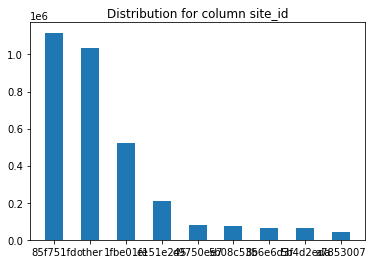

In [18]:
hist_bar_cat(train_3, "site_id")
# much better

#### site_domain

In [19]:
train_3['site_domain'].nunique()
# check non-dup value

4010

In [20]:
train_3['site_domain'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

48.12296789950277

In [21]:
categorical_replace(train_3, test, 'site_domain')

Train Test Replace Finished!
Test data replace finished!


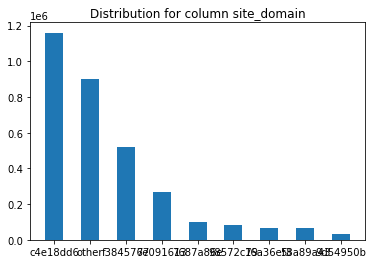

In [22]:
hist_bar_cat(train_3, "site_domain")
# much better

#### site_category

Use Label Encoder Later

In [23]:
train_3['site_category'].nunique()

23

### App Categories
#### app_id

In [24]:
train_3['app_id'].nunique()

4586

In [25]:
train_3['app_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

66.7564684913619

Train Test Replace Finished!
Test data replace finished!


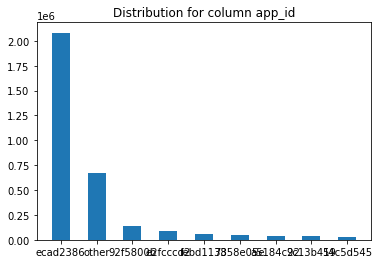

In [26]:
categorical_replace(train_3, test, 'app_id')
hist_bar_cat(train_3, "app_id")

#### app_domain

In [27]:
train_3['app_domain'].nunique()

294

In [28]:
train_3['app_domain'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

16.285788826071837

Train Test Replace Finished!
Test data replace finished!


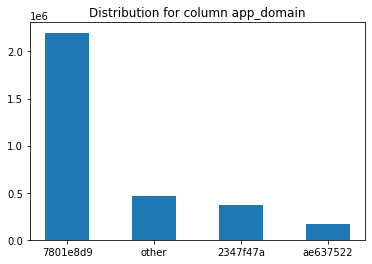

In [29]:
categorical_replace(train_3, test, 'app_domain', pct = 0.05)
hist_bar_cat(train_3, "app_domain")

#### app_category

Label Encode Later

In [30]:
train_3['app_category'].nunique()

27

### Device Categoris
#### device_id

In [31]:
train_3['device_id'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

646.6309681657631

Train Test Replace Finished!
Test data replace finished!


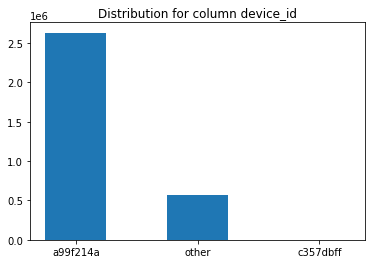

In [32]:
categorical_replace(train_3, test, 'device_id', pct = 0.0005)
hist_bar_cat(train_3, "device_id")

#### device_ip

In [33]:
train_3['device_ip'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

252.18416764934165

Train Test Replace Finished!
Test data replace finished!


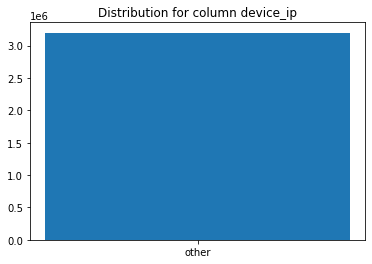

In [34]:
categorical_replace(train_3, test, 'device_ip')
hist_bar_cat(train_3, "device_ip")

This variable is too skew that we decide to drop it.

In [35]:
del train_3['device_ip']
del test['device_ip']

#### device_model

In [36]:
train_3['device_model'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

25.976421186589164

Train Test Replace Finished!
Test data replace finished!


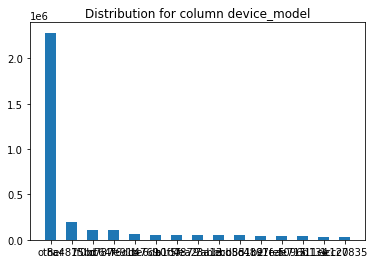

In [37]:
categorical_replace(train_3, test, 'device_model')
hist_bar_cat(train_3, "device_model")

### Anonymized Categorical Variables

#### C14

In [38]:
train_3['C14'].nunique()

2284

In [39]:
train_3['C14'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

7.99323307497523

Train Test Replace Finished!
Test data replace finished!


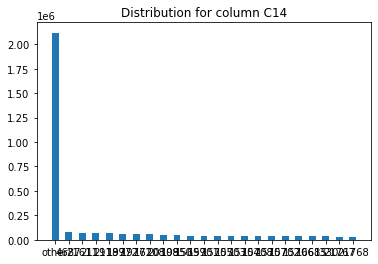

In [40]:
categorical_replace(train_3, test, 'C14', pct = 0.01)
hist_bar_cat(train_3, "C14")

#### C17

In [41]:
train_3['C17'].nunique()

405

In [42]:
train_3['C17'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

10.171913349163981

Train Test Replace Finished!
Test data replace finished!


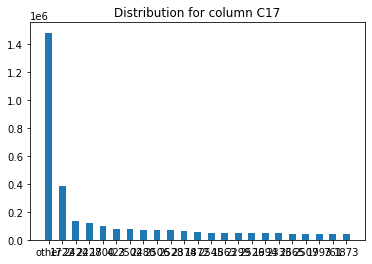

In [43]:
categorical_replace(train_3, test, 'C17')
hist_bar_cat(train_3, "C17")

#### C19

In [44]:
train_3['C19'].nunique()

65

In [45]:
train_3['C19'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

5.252812769397987

Train Test Replace Finished!
Test data replace finished!


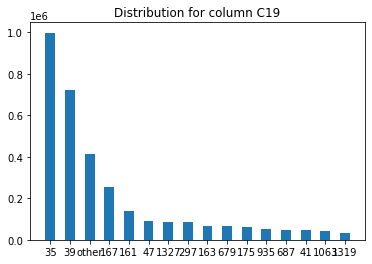

In [46]:
categorical_replace(train_3, test, 'C19')
hist_bar_cat(train_3, "C19")

#### C20

In [47]:
train_3['C20'].nunique()

168

In [48]:
train_3['C20'].value_counts(normalize = True).skew()
# as shown below, the skewness it is quite high

11.87592669177848

Train Test Replace Finished!
Test data replace finished!


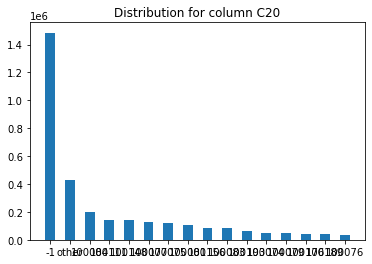

In [49]:
categorical_replace(train_3, test, 'C20')
hist_bar_cat(train_3, "C20")

#### C21

In [50]:
train_3['C21'].nunique()

55

In [51]:
train_3['C21'].value_counts(normalize = True).skew()
# as shown below, the skewness it is not quite high

3.6204617840011357

In [52]:
categorical_replace(train_3, test, 'C21')

Train Test Replace Finished!
Test data replace finished!


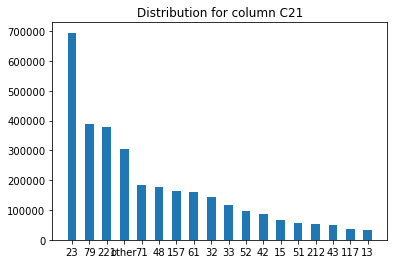

In [53]:
hist_bar_cat(train_3, "C21")

### Encoding

#### One-hot

In [54]:
# one-hot encoding: app_domain, device_id
encoder=ce.OneHotEncoder(cols=['app_domain','device_id'],handle_unknown='return_nan',return_df=True,use_cat_names=True)
one_hot_encoder = encoder.fit(train_3)

In [55]:
train_3 = one_hot_encoder.transform(train_3)

In [56]:
test = one_hot_encoder.transform(test)

#### Base 5 

In [57]:
# base 5 encoding: site_id, site_domain, app_id, C14, C17, C19, C20, C21
encoder1 = ce.BaseNEncoder(cols=['site_id','site_domain','app_id','C14','C17','C19','C20','C21'], return_df=True, base=5)
base_5_encoder = encoder1.fit(train_3)

In [58]:
train_3 = base_5_encoder.transform(train_3)

In [59]:
test = base_5_encoder.transform(test)

#### Base 10

In [60]:
# base 10 encoding: site_category, app_category, device_model
encoder2 = ce.BaseNEncoder(cols=['site_category','app_category','device_model'], return_df=True, base=10)
base_10_encoder = encoder2.fit(train_3)

In [61]:
train_3 = base_10_encoder.transform(train_3)

In [62]:
test = base_10_encoder.transform(test)

## Numerical Variables
* hour: detail shown below
* banner_pos: encoded by professor
* device_type: encoded by professor
* device_conn_type: encoded by professor

### Hour
- Day: week number
- Hour:
  - 1: 00-06
  - 2: 07-12
  - 3: 13-18
  - 4: 19-24

In [63]:
splitat = 6
train_3['day'], train_3['time'] = train_3['hour'].astype('str').str[:splitat], train_3['hour'].astype('str').str[splitat:].astype('int')

In [65]:
# time of day
def add_time_of_day(data):
    data['day'], data['time'] = data['hour'].astype('str').str[:splitat], data['hour'].astype('str').str[splitat:].astype('int')
    conditions = [(data.time <=6),
                (data.time > 6) & (data.time <= 12),
                (data.time > 12) & (data.time <= 18),
                (data.time >18)
                ]
    values = [1, 2, 3, 4]
    data['time_of_day'] = np.select(conditions, values, 0)

In [66]:
add_time_of_day(train_3)
add_time_of_day(test)

In [67]:
train_3[['day','time','hour','time_of_day']].head(5)

,day,time,hour,time_of_day
5616589,141022,10,14102210,2
31825749,141029,22,14102922,4
13548281,141024,13,14102413,3
11682204,141023,22,14102322,4
29186795,141029,4,14102904,1


In [68]:
def add_day_of_week(data):
    data['day']= pd.to_datetime(data['day'],format="%y%m%d")
    data['day_of_week'] = data['day'].dt.dayofweek

In [69]:
add_day_of_week(train_3)
add_day_of_week(test)

## Finalize the data

In [70]:
train_3.head()

,click,hour,C1,banner_pos,site_id_0,site_id_1,site_domain_0,site_domain_1,site_category_0,site_category_1,...,C19_0,C19_1,C20_0,C20_1,C21_0,C21_1,day,time,time_of_day,day_of_week
5616589,0,14102210,1005,1,0,1,0,1,0,1,...,0,1,0,1,0,1,2014-10-22,10,2,2
31825749,0,14102922,1005,0,0,2,0,2,0,2,...,0,2,0,2,0,2,2014-10-29,22,4,2
13548281,1,14102413,1005,0,0,1,0,1,0,1,...,0,2,0,2,0,3,2014-10-24,13,3,4
11682204,0,14102322,1005,0,0,2,0,2,0,2,...,0,1,0,3,0,4,2014-10-23,22,4,3
29186795,0,14102904,1005,0,0,1,0,1,0,3,...,0,3,0,3,0,3,2014-10-29,4,1,2


In [73]:
x_col = ['C1', 'banner_pos', 'site_id_0', 'site_id_1',
       'site_domain_0', 'site_domain_1', 'site_category_0', 'site_category_1',
       'app_id_0', 'app_id_1', 'app_domain_7801e8d9', 'app_domain_ae637522',
       'app_domain_2347f47a', 'app_domain_other', 'app_category_0',
       'app_category_1', 'device_id_other', 'device_id_a99f214a',
       'device_id_c357dbff', 'device_model_0', 'device_model_1', 'device_type', 'device_conn_type',
       'C14_0', 'C14_1', 'C15', 'C16', 'C17_0', 'C17_1', 'C18', 'C19_0',
       'C19_1', 'C20_0', 'C20_1', 'C21_0', 'C21_1',
       'time_of_day', 'day_of_week']
y_col = 'click'

In [74]:
X_train3 = train_3[x_col]
y_train3 = train_3[y_col]
X_test = test[x_col]
y_pred_naive = test[y_col]

# Model Training

In [96]:
# Split to Sub-train & Validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train3, y_train3, test_size=0.2, random_state=42)

## Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
lr = LogisticRegression(random_state=42, n_jobs=-1, penalty="l2").fit(X_train, y_train)

/Users/rebecca/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
y_pred = lr.predict_proba(X_val)

In [79]:
# print log loss of the validation data
log_loss(y_val, y_pred)

0.4360344851617682

Since the log-loss is quite high, LR is not a great model to be chosen as a final step.

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
rfc=RandomForestClassifier(random_state=42)

Random Serach using random forest

In [113]:
rs_space={'max_depth':[20,30],
              'n_estimators':[100, 200, 300],
              'max_features':['sqrt', 'log2'],
              'min_samples_split':[50, 100]
         }

In [292]:
# param_grid = { 
#     'n_estimators': [100, 200, 300, 400],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 10, 100],
#     'max_depth' : [10,20,30],
# }
# gs_rfc = GridSearchCV(estimator=rfc,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_log_loss',
#     n_jobs=-1, 
#     verbose = 3)
# gs_rfc.fit(X_train, y_train)

In [118]:
from tune_sklearn import TuneGridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [125]:
rfc_random = RandomizedSearchCV(rfc, rs_space, 
                                scoring='neg_log_loss', 
                                n_jobs=-1, 
                                cv=2,
                                n_iter=10,
                                verbose=30)

In [144]:
rfc_random.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 2/2; 3/10] START max_depth=30, max_features=sqrt, min_samples_split=50, n_estimators=300
[CV 2/2; 1/10] START max_depth=20, max_features=sqrt, min_samples_split=50, n_estimators=300
[CV 1/2; 3/10] START max_depth=30, max_features=sqrt, min_samples_split=50, n_estimators=300
[CV 1/2; 1/10] START max_depth=20, max_features=sqrt, min_samples_split=50, n_estimators=300
[CV 1/2; 2/10] START max_depth=30, max_features=sqrt, min_samples_split=100, n_estimators=100
[CV 2/2; 4/10] START max_depth=20, max_features=sqrt, min_samples_split=50, n_estimators=100
[CV 1/2; 4/10] START max_depth=20, max_features=sqrt, min_samples_split=50, n_estimators=100
[CV 2/2; 2/10] START max_depth=30, max_features=sqrt, min_samples_split=100, n_estimators=100


KeyboardInterrupt: 

In [ ]:
print("Parameter: ", rfc_random.best_params_)
print("Non-nested LogLoss: ", rfc_random.best_score_)
print("Best Estimator: ", rfc_random.best_estimator_)

In [117]:
rf = RandomForestClassifier(n_estimators = 100, 
                            random_state = 42, 
                            min_samples_split=300, 
                            max_depth=30,
                            n_jobs=-1)

In [ ]:
rf.fit(X_train, y_train)

In [358]:
y_pred_rf = rf.predict_proba(X_val)
log_loss(y_val, y_pred_rf)
# .40227452244706247

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


0.40391179841269653

## Neural Net

In [87]:
# initialize nn
nnc = Sequential()
# add input layer
nnc.add(Dense(10, kernel_regularizer = regularizers.l2(0.003), kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu', input_shape = (X_train.shape[1],), use_bias=True))
nnc.add(Dropout(0.4))
# add hidden layer
nnc.add(Dense(10, kernel_regularizer = regularizers.l2(0.003), kernel_initializer=initializers.RandomNormal(stddev=0.01), activation='relu'))
nnc.add(Dropout(0.3))
nnc.add(Dense(units = 6, activation = 'sigmoid', use_bias = True))
# add output layer
nnc.add(Dense(1, activation = 'sigmoid', use_bias = True))
nnc.compile(optimizer = Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-12-05 17:21:14.358862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
nnc.fit(X_train, y_train, epochs=10, batch_size = 512, validation_data = (X_val, y_val))

Epoch 1/10
4374/4374 [==============================] - 8s 2ms/step - loss: 0.4494 - accuracy: 0.8302 - val_loss: 0.4479 - val_accuracy: 0.8303
Epoch 2/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4493 - accuracy: 0.8302 - val_loss: 0.4478 - val_accuracy: 0.8303
Epoch 3/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4493 - accuracy: 0.8302 - val_loss: 0.4485 - val_accuracy: 0.8303
Epoch 4/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4504 - accuracy: 0.8302 - val_loss: 0.4483 - val_accuracy: 0.8303
Epoch 5/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4516 - accuracy: 0.8302 - val_loss: 0.4501 - val_accuracy: 0.8303
Epoch 6/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4520 - accuracy: 0.8302 - val_loss: 0.4498 - val_accuracy: 0.8303
Epoch 7/10
4374/4374 [==============================] - 6s 1ms/step - loss: 0.4532 - accuracy: 0.8302 - val_loss: 0.4534 - val_accuracy:

In [89]:
y_pred_nn = nnc.predict(X_val)
log_loss(y_val, y_pred_nn)

29992/29992 [==============================] - 17s 570us/step


0.4554982736349612

## LightGBM

In [83]:
lgb = LGBMClassifier(random_state=42)

In [84]:
lgb.fit(X_train,y_train,verbose=3,eval_metric='logloss')

LGBMClassifier(random_state=42)

In [86]:
parameters = {
    'learning_rate': [0.01,0.05,0.09,0.1],
    'num_leaves': [31,250,300],
}

gbm = LGBMClassifier(objective='binary', 
                          n_jobs=-1,
                          metric = 'binary_logloss',
                          boosting_type='gbdt',
                          cat_smooth= 35)
gs_lgb = GridSearchCV(gbm, param_grid=parameters, scoring='neg_log_loss', cv=3, verbose = 3)

In [278]:
gs_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 1/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=  12.4s
[CV 2/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 2/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=   9.9s
[CV 3/3; 1/12] START learning_rate=0.01, num_leaves=31..........................
[CV 3/3; 1/12] END learning_rate=0.01, num_leaves=31;, score=-0.425 total time=   9.8s
[CV 1/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 1/3; 2/12] END learning_rate=0.01, num_leaves=250;, score=-0.417 total time=  14.9s
[CV 2/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 2/3; 2/12] END learning_rate=0.01, num_leaves=250;, score=-0.417 total time=  14.9s
[CV 3/3; 2/12] START learning_rate=0.01, num_leaves=250.........................
[CV 3/3; 2/12] E

GridSearchCV(cv=3,
             estimator=LGBMClassifier(cat_smooth=35, metric='binary_logloss',
                                      objective='binary'),
             param_grid={'learning_rate': [0.01, 0.05, 0.09, 0.1],
                         'num_leaves': [31, 250, 300]},
             scoring='neg_log_loss', verbose=35)

In [279]:
print('best parameter:{0}'.format(gs_lgb.best_params_))
print('best logloss:{0}'.format(-gs_lgb.best_score_))
print(-gs_lgb.cv_results_['mean_test_score'])
print(gs_lgb.cv_results_['params'])

best parameter:{'learning_rate': 0.1, 'num_leaves': 300}
best logloss:0.40284256869548624
[0.42493007 0.4167635  0.4161361  0.41145756 0.40401134 0.4036137
 0.40933394 0.40322167 0.40294127 0.40888987 0.40307371 0.40284257]
[{'learning_rate': 0.01, 'num_leaves': 31}, {'learning_rate': 0.01, 'num_leaves': 250}, {'learning_rate': 0.01, 'num_leaves': 300}, {'learning_rate': 0.05, 'num_leaves': 31}, {'learning_rate': 0.05, 'num_leaves': 250}, {'learning_rate': 0.05, 'num_leaves': 300}, {'learning_rate': 0.09, 'num_leaves': 31}, {'learning_rate': 0.09, 'num_leaves': 250}, {'learning_rate': 0.09, 'num_leaves': 300}, {'learning_rate': 0.1, 'num_leaves': 31}, {'learning_rate': 0.1, 'num_leaves': 250}, {'learning_rate': 0.1, 'num_leaves': 300}]


In [114]:
lgb = LGBMClassifier(learning_rate=0.1,num_leaves = 300,random_state=42, metric = 'binary_logloss',cat_smooth= 35).\
    fit(X_train, y_train,eval_metric='logloss')

In [115]:
y_pred_lgb=lgb.predict_proba(X_val)[:, 1]

In [289]:
log_loss(y_val, y_pred_lgb)

0.40189174104048725

## CatBoost

In [90]:
from catboost import CatBoostClassifier, Pool

In [92]:
ctb = CatBoostClassifier(random_seed=42)

In [93]:
ctb.fit(X_train, y_train)

Learning rate set to 0.277612
0:	learn: 0.5546360	total: 286ms	remaining: 4m 46s
1:	learn: 0.4901436	total: 466ms	remaining: 3m 52s
2:	learn: 0.4580588	total: 677ms	remaining: 3m 45s
3:	learn: 0.4419956	total: 875ms	remaining: 3m 37s
4:	learn: 0.4337565	total: 1.09s	remaining: 3m 37s
5:	learn: 0.4287606	total: 1.29s	remaining: 3m 34s
6:	learn: 0.4262102	total: 1.58s	remaining: 3m 44s
7:	learn: 0.4243884	total: 1.75s	remaining: 3m 37s
8:	learn: 0.4233272	total: 1.94s	remaining: 3m 33s
9:	learn: 0.4221519	total: 2.12s	remaining: 3m 30s
10:	learn: 0.4211780	total: 2.31s	remaining: 3m 28s
11:	learn: 0.4200521	total: 2.5s	remaining: 3m 25s
12:	learn: 0.4192943	total: 2.71s	remaining: 3m 25s
13:	learn: 0.4189905	total: 2.9s	remaining: 3m 24s
14:	learn: 0.4184677	total: 3.09s	remaining: 3m 23s
15:	learn: 0.4181608	total: 3.27s	remaining: 3m 20s
16:	learn: 0.4178235	total: 3.46s	remaining: 3m 20s
17:	learn: 0.4173590	total: 3.65s	remaining: 3m 19s
18:	learn: 0.4171426	total: 3.84s	remaining: 3

In [94]:
y_pred_ctb=ctb.predict_proba(X_val)[:, 1]

In [343]:
log_loss(y_val, y_pred_ctb)

0.40239392328189716

# Final Result

Lightgbm

In [132]:
y_sub = lgb.predict_proba(X_test)[:,1]

In [133]:
# Import the submission data
sub = pd.read_csv('Project Data/ProjectSubmission-Team4.csv')

In [140]:
sub.iloc[:,1] = y_sub

In [145]:
sub.to_csv('ProjectSubmission-Team4.csv',index = False)